In [1]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [2]:
!ls /kaggle/input/dalle-recognition-dataset

fakeV2	real


In [3]:
import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
import torch
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.metrics import (
    roc_auc_score,confusion_matrix,f1_score,
    accuracy_score,classification_report
)
from transformers import (
    TrainingArguments,Trainer,ViTImageProcessor,
    ViTForImageClassification,DefaultDataCollator
)
from torchvision.transforms import (
    RandomResizedCrop,RandomRotation,
    RandomHorizontalFlip,Normalize,
    RandomAdjustSharpness,Compose,
    Resize,ToTensor,CenterCrop
)
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 1_000_000_000
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
import pandas as pd
from tqdm import tqdm
import os

file_names,labels = [],[]
directory = '/kaggle/input/dalle-recognition-dataset'
with tqdm(21638) as pbar :
    for root,dirs,files in os.walk(directory):
        for file in files :
            path = os.path.join(root,file)
            if path.endswith('png') or path.endswith('jpg') :
                file_names.append(path)
                labels.append(path.split('/')[-2])
            pbar.update(1)

print(len(file_names), len(labels))

21638it [00:10, 2113.94it/s]

21635 21635


In [6]:
df = pd.DataFrame({"image": file_names, "label": labels})
df.shape
df.head()

,image,label
0,/kaggle/input/dalle-recognition-dataset/real/1...,real
1,/kaggle/input/dalle-recognition-dataset/real/6...,real
2,/kaggle/input/dalle-recognition-dataset/real/2...,real
3,/kaggle/input/dalle-recognition-dataset/real/2...,real
4,/kaggle/input/dalle-recognition-dataset/real/2...,real


In [7]:
df['image'][0]

'/kaggle/input/dalle-recognition-dataset/real/1269.jpg'

In [8]:
ros = RandomOverSampler(random_state=7*13)
df['label'] = df['label'].map({'real':'REAL','fake-v2':'FAKE'})
df, y_resampled = ros.fit_resample(df.drop(columns=['label']), df['label'])
df['label'] = y_resampled
gc.collect()
print(df.shape)

(35710, 2)


In [9]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

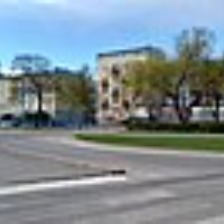

In [10]:
dataset[0]["image"]

In [11]:
labels_list = ['REAL', 'FAKE']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'REAL', 1: 'FAKE'} 

Mapping of Labels to IDs: {'REAL': 0, 'FAKE': 1}


In [12]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/35710 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/35710 [00:00<?, ? examples/s]

In [13]:
model_str = 'google/vit-base-patch16-224-in21k' #"dima806/ai_vs_real_image_detection" #

processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        ToTensor(),
        normalize
    ]
)
_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [14]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [15]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [16]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [17]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }

In [18]:
metric_name = "accuracy"
model_name = "ai_vs_real_image_detection_V0"
num_train_epochs = 2

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='/kaggle/working/logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [20]:
trainer.evaluate()

{'eval_loss': 0.6843992471694946,
 'eval_accuracy': 0.5639876785214226,
 'eval_runtime': 292.0122,
 'eval_samples_per_second': 24.458,
 'eval_steps_per_second': 0.384}

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.651898,0.710865
2,No log,0.636335,0.750910


TrainOutput(global_step=448, training_loss=0.6338120188031878, metrics={'train_runtime': 3281.7065, 'train_samples_per_second': 17.41, 'train_steps_per_second': 0.137, 'total_flos': 4.4275823186193285e+18, 'train_loss': 0.6338120188031878, 'epoch': 2.0})

In [22]:
trainer.evaluate()

{'eval_loss': 0.6363345980644226,
 'eval_accuracy': 0.7509101092131055,
 'eval_runtime': 240.3557,
 'eval_samples_per_second': 29.714,
 'eval_steps_per_second': 0.466,
 'epoch': 2.0}

In [23]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.6363345980644226, 'test_accuracy': 0.7509101092131055, 'test_runtime': 237.5077, 'test_samples_per_second': 30.071, 'test_steps_per_second': 0.472}


Accuracy: 0.7509
F1 Score: 0.7477


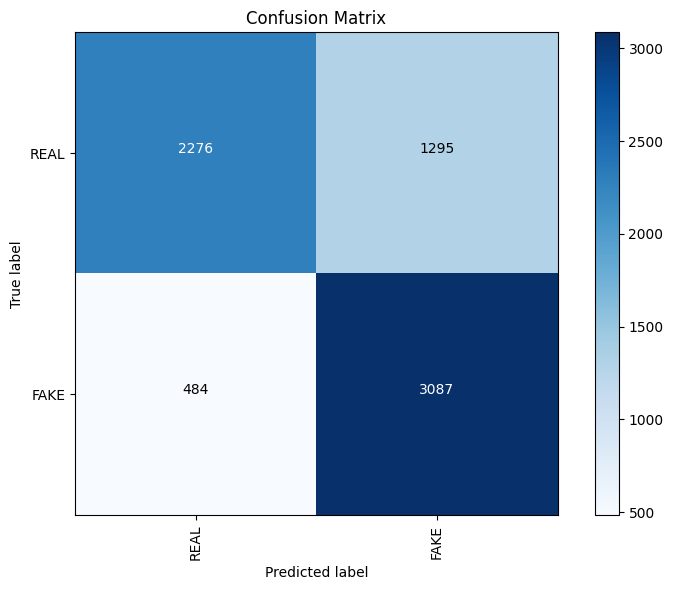

Classification report:
              precision    recall  f1-score   support

        REAL     0.8246    0.6374    0.7190      3571
        FAKE     0.7045    0.8645    0.7763      3571

    accuracy                         0.7509      7142
   macro avg     0.7646    0.7509    0.7477      7142
weighted avg     0.7646    0.7509    0.7477      7142



In [24]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(20, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [25]:
trainer.save_model()

In [26]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

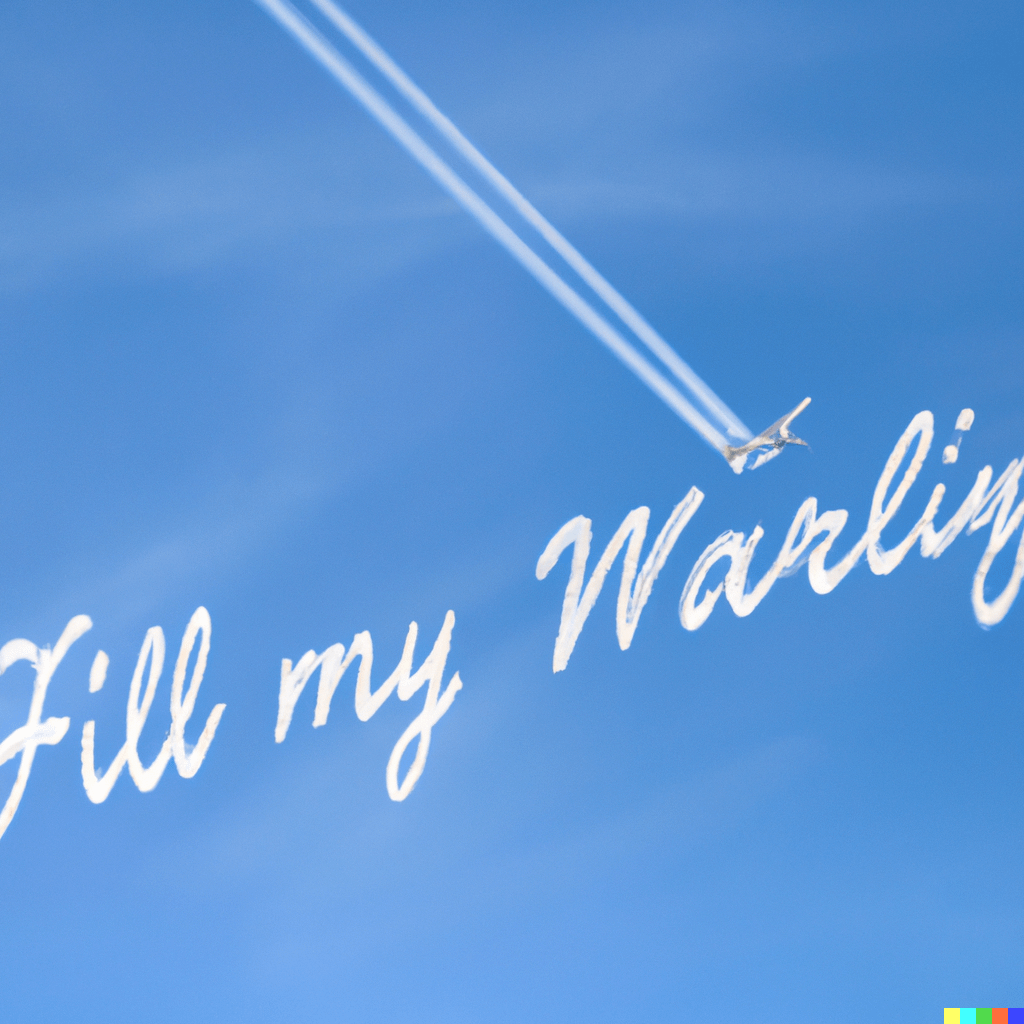

In [27]:
image = test_data[1]["image"]
image

In [28]:
pipe(image)

[{'label': 'REAL', 'score': 0.5144864916801453},
 {'label': 'FAKE', 'score': 0.4441530108451843}]

In [35]:
from huggingface_hub import notebook_login
notebook_login()

In [40]:
from huggingface_hub import whoami

user_info = whoami()
username = user_info['name']
print(f"Your username is: {username}")

Your username is: R1Amine


In [41]:
from huggingface_hub import HfApi

api = HfApi()
repo_id = f"R1Amine/{model_name.lower()}"
api.create_repo(repo_id)

RepoUrl('https://huggingface.co/R1Amine/ai_vs_real_image_detection_v0', endpoint='https://huggingface.co', repo_type='model', repo_id='R1Amine/ai_vs_real_image_detection_v0')

In [42]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo=".",
    repo_id=repo_id,
    repo_type="model",
    revision="main"
)

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/R1Amine/ai_vs_real_image_detection_v0/commit/201bded01df810b6756ddae69e8339e80512605c', commit_message='Upload folder using huggingface_hub', commit_description='', oid='201bded01df810b6756ddae69e8339e80512605c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/R1Amine/ai_vs_real_image_detection_v0', endpoint='https://huggingface.co', repo_type='model', repo_id='R1Amine/ai_vs_real_image_detection_v0'), pr_revision=None, pr_num=None)